Goal of this file: 
* To understand and process data to later analyze in R using `highfrequency`
* Create quotes and trade tables in the format required by `highfrequency`

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm

In [49]:
# To see progress bars when applying column-wise functions
tqdm.pandas()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# First glance at data
We develop the main intuitions here before making the process automatic

In [65]:
%%time
df = pd.read_excel('new_data/Facebook - FE570.xlsx', sheet_name=0, skiprows=6, dtype=str)

Wall time: 2min 46s


In [66]:
df.head()

,Unnamed: 0,Unnamed: 1,Dates,Type,Price,Size,Unnamed: 6,Dates.1,Type.1,Price.1,Size.1,Unnamed: 11,Dates.2,Type.2,Price.2,Size.2
0,NaN,NaN,2020-11-03 09:00:12,BEST_BID,262.5,6,NaN,2020-11-03 09:01:33,BEST_ASK,262.73,6,NaN,2020-11-03 09:30:00,TRADE,263.16,123
1,NaN,NaN,2020-11-03 09:00:21,BEST_BID,262.6,1,NaN,2020-11-03 09:04:25,BEST_ASK,262.71,1,NaN,2020-11-03 09:30:00,TRADE,263.16,200
2,NaN,NaN,2020-11-03 09:00:47,BEST_BID,262.62,1,NaN,2020-11-03 09:04:25,BEST_ASK,262.73,6,NaN,2020-11-03 09:30:00,TRADE,263.18,140358
3,NaN,NaN,2020-11-03 09:00:47,BEST_BID,262.62,2,NaN,2020-11-03 09:04:35,BEST_ASK,262.7,1,NaN,2020-11-03 09:30:00,TRADE,263.2,100
4,NaN,NaN,2020-11-03 09:00:47,BEST_BID,262.62,1,NaN,2020-11-03 09:05:24,BEST_ASK,262.71,1,NaN,2020-11-03 09:30:00,TRADE,263.2,100


In [222]:
bid = df[['Dates', 'Type', 'Price', 'Size']].dropna()
assert set(bid['Type']) == {'BEST_BID'}

In [223]:
ask = df[['Dates.1', 'Type.1', 'Price.1', 'Size.1']].dropna()
assert set(ask['Type.1']) == {'BEST_ASK'}

AssertionError: 

In [256]:
trade = df[['Dates.2', 'Type.2', 'Price.2', 'Size.2']].dropna()
assert set(trade['Type.2']) == {'TRADE'}

Fix weird entry in ask table - eventually this test will need to be run for all tables

In [224]:
ask['Type.1'].value_counts()

BEST_ASK    210552
Type             1
Name: Type.1, dtype: int64

In [225]:
ask = ask[ask['Type.1']=='BEST_ASK']
assert set(ask['Type.1']) == {'BEST_ASK'}

## Fix dates

Some dates are as datetime entries, others as floats

Due to roundup errors, round every timestamp to closest second

Excel year 1 is January 1, 1900 - so there are approximately 70 years of difference here

In [227]:
def convert_excel_time(x):
    
    try:
        return pd.to_datetime(float(x), unit='d')-pd.DateOffset(years=70, days=2)
    except ValueError:
        try:
            return pd.to_datetime(x)
        except ValueError:
            print(x)
            return np.nan

In [228]:
%%time
bid['Dates'] = bid['Dates'].progress_apply(convert_excel_time)
bid['Dates'] = bid['Dates'].dt.round(freq='s')

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Wall time: 1min 8s


In [229]:
%%time
ask['Dates.1'] = ask['Dates.1'].progress_apply(convert_excel_time)
ask['Dates.1'] = ask['Dates.1'].dt.round(freq='s')


Wall time: 1min 17s


In [257]:
%%time
trade['Dates.2'] = trade['Dates.2'].progress_apply(convert_excel_time)
trade['Dates.2'] = trade['Dates.2'].dt.round(freq='s')

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Wall time: 25.1 s


## Fix numeric values

### Prices

In [230]:
for col in ['Price', 'Size']:
    bid[col] = bid[col].astype(float)

In [231]:
for col in ['Price.1', 'Size.1']:
    ask[col] = ask[col].astype(float)

In [260]:
for col in ['Price.2', 'Size.2']:
    trade[col] = trade[col].astype(float)

## Remove outliers

Bid and ask seem to have no outliers - in particular, no zero prices or volumes and maximum size is in the hundreds

In [233]:
bid.describe()

,Price,Size
count,198335.000000,198335.000000
mean,266.746013,2.143938
std,1.628315,3.665424
min,260.870000,1.000000
25%,266.200000,1.000000
50%,266.950000,2.000000
75%,267.780000,2.000000
max,270.020000,318.000000


In [234]:
ask.describe()

,Price.1,Size.1
count,210552.000000,210552.000000
mean,266.743314,2.223346
std,1.646023,3.370082
min,260.930000,1.000000
25%,266.180000,1.000000
50%,266.990000,2.000000
75%,267.810000,3.000000
max,270.090000,169.000000


Trade however seems to have outliers - maximum size is too high, minimum size is zero

In [261]:
trade.describe()

,Price.2,Size.2
count,66056.000000,6.605600e+04
mean,266.662658,2.089731e+02
std,1.709322,4.028277e+03
min,260.880000,0.000000e+00
25%,266.020000,1.000000e+02
50%,266.890000,1.000000e+02
75%,267.800000,1.500000e+02
max,270.050000,1.022156e+06


Dealing with size = 0 entries:

In [262]:
print(f"{round(100*(trade['Size.2'] == 0).sum()/len(trade),3)} % of trade data have size = 0")

0.002 % of trade data have size = 0


In [263]:
trade = trade[trade['Size.2'] > 0]

Dealing with outliers:

In [264]:
for thresh in [100,1000,10000,100000]:
    print(f"{round(100*(trade['Size.2'] > thresh).sum()/len(trade),3)} % of trade data have size > {thresh}")

28.902 % of trade data have size > 100
2.151 % of trade data have size > 1000
0.011 % of trade data have size > 10000
0.003 % of trade data have size > 100000


**Important**: We will keep trades with less than 1000

In [265]:
trade = trade[trade['Size.2'] <= 1000]

## Combine equal timestamps
Strategy: keep highest-size entry only, untie randomly

In [267]:
bid = bid.drop_duplicates()
ask = ask.drop_duplicates()
trade = trade.drop_duplicates()

In [268]:
bid = bid.sort_values(['Dates', 'Size']).groupby(['Dates', 'Type']).tail(1)
ask = ask.sort_values(['Dates.1', 'Size.1']).groupby(['Dates.1', 'Type.1']).tail(1)
trade = trade.sort_values(['Dates.2', 'Size.2']).groupby(['Dates.2', 'Type.2']).tail(1)

## Rename columns + set index

In [242]:
bid = bid.rename({'Price': 'BID', 'Size': 'BIDSIZ'}, axis=1).set_index('Dates')

In [243]:
ask = ask.rename({'Price.1': 'OFR', 'Size.1': 'OFRSIZ'}, axis=1).set_index('Dates.1')

In [270]:
trade = trade.rename({'Price.2': 'PRICE', 'Size.2': 'SIZE'}, axis=1).set_index('Dates.2')

# Merge quotes data

In [245]:
print(f"Length of original data: ask = {len(ask)}, bid = {len(bid)}")
qdata = bid.join(ask, how='inner')
print(f"Length of merged data: {len(qdata)}")

Length of original data: ask = 18024, bid = 17912
Length of merged data: 15365


In [246]:
qdata = qdata[['BID', 'BIDSIZ', 'OFR', 'OFRSIZ']]

In [247]:
qdata['date'] = qdata.index.date
qdata['hour'] = qdata.index.time

In [272]:
trade['date'] = trade.index.date
trade['hour'] = trade.index.time

In [248]:
qdata.head()

,BID,BIDSIZ,OFR,OFRSIZ,date,hour
2020-11-03 09:05:40,262.58,3.0,262.73,5.0,2020-11-03,09:05:40
2020-11-03 09:05:42,262.73,1.0,262.98,1.0,2020-11-03,09:05:42
2020-11-03 09:07:25,262.70,6.0,262.95,5.0,2020-11-03,09:07:25
2020-11-03 09:08:54,262.67,1.0,262.85,6.0,2020-11-03,09:08:54
2020-11-03 09:10:56,262.69,1.0,262.82,2.0,2020-11-03,09:10:56


In [249]:
assert len(set(qdata['date'])) == 1, 'More than one day contained in this data'

## Remove data before/after close

In [250]:
qdata = qdata[(qdata['hour'] >= datetime.time(9,30,0)) & (qdata['hour'] <= datetime.time(16,0,0))]

In [273]:
trade = trade[(trade['hour'] >= datetime.time(9,30,0)) & (trade['hour'] <= datetime.time(16,0,0))]

## Remove very large spreads
`highfrequency` library uses a standard of 50 - i.e. spreads larger than 50 times the median spread are removed

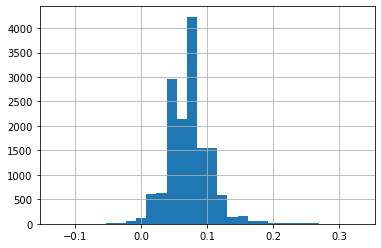

In [305]:
(qdata['OFR'] - qdata['BID']).hist(bins=30)
plt.show()

In [310]:
med_spread = (qdata['OFR'] - qdata['BID']).abs().median() # using the absolute value to make sure this is a positive number
print(f"Median spread is {med_spread}")
l0 = len(qdata)
qdata = qdata[(qdata['OFR'] - qdata['BID']).abs() < 50*med_spread]
print(f"New length: {len(qdata)} vs. old length: {l0}")

Median spread is 0.06999999999999318
New length: 14993 vs. old length: 14993


## Plot

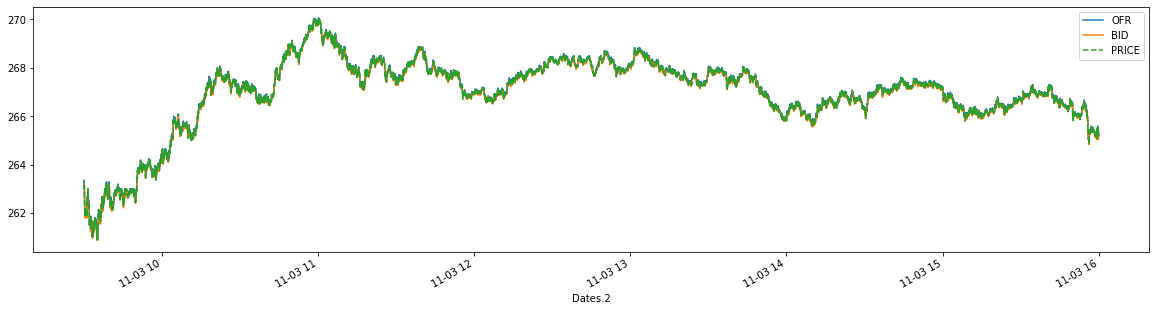

In [282]:
fig, ax = plt.subplots(figsize=(20,5))
qdata[['OFR', 'BID']].plot(ax=ax)
trade['PRICE'].plot(ax=ax, linestyle='--', legend='TRADE')
plt.show()

# Make this into a function

In [292]:
def process_tqdata(excel_file, sheet_name):
    
    print(f"Reading file {excel_file}...")
    df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=6, dtype=str)

    bid = df[['Dates', 'Type', 'Price', 'Size']].dropna()
    print(bid['Type'].value_counts())

    ask = df[['Dates.1', 'Type.1', 'Price.1', 'Size.1']].dropna()
    print(ask['Type.1'].value_counts())

    trade = df[['Dates.2', 'Type.2', 'Price.2', 'Size.2']].dropna()
    print(trade['Type.2'].value_counts())

    # Keep only regular data
    bid = bid[bid['Type']=='BEST_BID']
    ask = ask[ask['Type.1']=='BEST_ASK']
    trade = trade[trade['Type.2']=='TRADE']
    

    ## Fix dates
    def convert_excel_time(x):

        try:
            return pd.to_datetime(float(x), unit='d')-pd.DateOffset(years=70, days=2)
        except ValueError:
            try:
                return pd.to_datetime(x)
            except ValueError:
                print(x)
                return np.nan

    print("Fixing datetime...")
    bid['Dates'] = bid['Dates'].progress_apply(convert_excel_time)
    bid['Dates'] = bid['Dates'].dt.round(freq='s')

    ask['Dates.1'] = ask['Dates.1'].progress_apply(convert_excel_time)
    ask['Dates.1'] = ask['Dates.1'].dt.round(freq='s')

    trade['Dates.2'] = trade['Dates.2'].progress_apply(convert_excel_time)
    trade['Dates.2'] = trade['Dates.2'].dt.round(freq='s')

    print('Fix numeric values')
    for col in ['Price', 'Size']:
        bid[col] = bid[col].astype(float)

    for col in ['Price.1', 'Size.1']:
        ask[col] = ask[col].astype(float)

    for col in ['Price.2', 'Size.2']:
        trade[col] = trade[col].astype(float)

    print("Checking for outliers...")
    print(">> BID")
    print(bid.describe())
    
    print(">> ASK")
    print(ask.describe())

    print(">> TRADE")
    print(trade.describe())
    
    print("Removing very small sizes, sizes higher than 10000, and zero prices")
    bid = bid[(bid['Size'] > 0) & (bid['Size'] < 10000) & (bid['Price'] > 0)]
    ask = ask[(ask['Size.1'] > 0) & (ask['Size.1'] < 10000) & (ask['Price.1'] > 0)]
    trade = trade[(trade['Size.2'] > 0) & (trade['Size.2'] < 10000) & (trade['Price.2'] > 0)]

    print("Combine equal timestamps")
    bid = bid.drop_duplicates()
    ask = ask.drop_duplicates()
    trade = trade.drop_duplicates()

    bid = bid.sort_values(['Dates', 'Size']).groupby(['Dates', 'Type']).tail(1)
    ask = ask.sort_values(['Dates.1', 'Size.1']).groupby(['Dates.1', 'Type.1']).tail(1)
    trade = trade.sort_values(['Dates.2', 'Size.2']).groupby(['Dates.2', 'Type.2']).tail(1)

    # Rename columns
    bid = bid.rename({'Price': 'BID', 'Size': 'BIDSIZ'}, axis=1).set_index('Dates')
    ask = ask.rename({'Price.1': 'OFR', 'Size.1': 'OFRSIZ'}, axis=1).set_index('Dates.1')
    trade = trade.rename({'Price.2': 'PRICE', 'Size.2': 'SIZE'}, axis=1).set_index('Dates.2')

    # Merge quotes data
    print("Merge quotes data:")
    print(f"> Length of original data: ask = {len(ask)}, bid = {len(bid)}")
    qdata = bid.join(ask, how='inner')
    print(f"> Length of merged data: {len(qdata)}")

    qdata = qdata[['BID', 'BIDSIZ', 'OFR', 'OFRSIZ']]

    qdata['date'] = qdata.index.date
    qdata['hour'] = qdata.index.time

    trade['date'] = trade.index.date
    trade['hour'] = trade.index.time


    assert len(set(qdata['date'])) == 1, f"{len(set(qdata['date']))} different dates contained here"

    ## Remove data before/after close
    qdata = qdata[(qdata['hour'] >= datetime.time(9,30,0)) & (qdata['hour'] <= datetime.time(16,0,0))]
    trade = trade[(trade['hour'] >= datetime.time(9,30,0)) & (trade['hour'] <= datetime.time(16,0,0))]

    # Remove large spreads
    med_spread = (qdata['OFR'] - qdata['BID']).abs().median() # using the absolute value to make sure this is a positive number
    qdata = qdata[(qdata['OFR'] - qdata['BID']).abs() < 50*med_spread]
    
    # Plot results    
    fig, ax = plt.subplots(figsize=(20,5))
    qdata[['OFR', 'BID']].plot(ax=ax)
    trade['PRICE'].plot(ax=ax, linestyle='--', legend='TRADE')
    plt.show()
    
    # reset index
    qdata.index.rename('t', inplace=True)
    qdata = qdata.reset_index()
    
    trade.index.rename('t', inplace=True)
    trade = trade.reset_index()
    
    return qdata, trade

# Facebook

BEST_BID    198335
Name: Type, dtype: int64
BEST_ASK    210552
Type             1
Name: Type.1, dtype: int64
TRADE    66056
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  198335.000000  198335.000000
mean      266.746013       2.143938
std         1.628315       3.665424
min       260.870000       1.000000
25%       266.200000       1.000000
50%       266.950000       2.000000
75%       267.780000       2.000000
max       270.020000     318.000000
>> ASK
             Price.1         Size.1
count  210552.000000  210552.000000
mean      266.743314       2.223346
std         1.646023       3.370082
min       260.930000       1.000000
25%       266.180000       1.000000
50%       266.990000       2.000000
75%       267.810000       3.000000
max       270.090000     169.000000
>> TRADE
            Price.2        Size.2
count  66056.000000  6.605600e+04
mean     266.662658  2.089731e+02
std        1.709322  4.028277e+03
min      260.880000  0.000000e+00
25%      266.020000  1.000000e+02
50%      266.890000  1.000000e+02
75%      267.800000  1.500000e+02
max      270

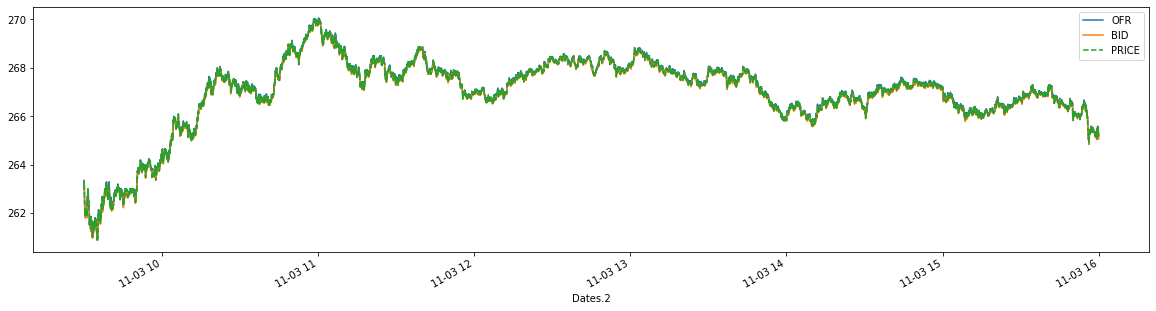

In [289]:
q, t = process_tqdata('new_data/Facebook - FE570.xlsx', sheet_name=0)

In [291]:
t.to_csv('new_data/processed/Facebook_1_t.csv')
q.to_csv('new_data/processed/Facebook_1_q.csv')

Reading file new_data/Facebook - FE570.xlsx...
BEST_BID    209593
Name: Type, dtype: int64
BEST_ASK    195510
Name: Type.1, dtype: int64
TRADE    58147
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  209593.000000  209593.000000
mean      275.765215       2.337611
std         0.861350       2.386163
min       272.660000       1.000000
25%       275.210000       1.000000
50%       275.630000       2.000000
75%       276.330000       3.000000
max       278.370000     126.000000
>> ASK
             Price.1         Size.1
count  195510.000000  195510.000000
mean      275.816043       2.429891
std         0.874935       3.316964
min       272.750000       1.000000
25%       275.240000       1.000000
50%       275.700000       2.000000
75%       276.440000       3.000000
max       278.410000     248.000000
>> TRADE
            Price.2        Size.2
count  58147.000000  5.814700e+04
mean     275.850585  1.925729e+02
std        0.985063  4.488515e+03
min      272.480000  0.000000e+00
25%      275.230000  1.000000e+02
50%      275.755000  1.000000e+02
75%      276.530000  1.200000e+02
max      278

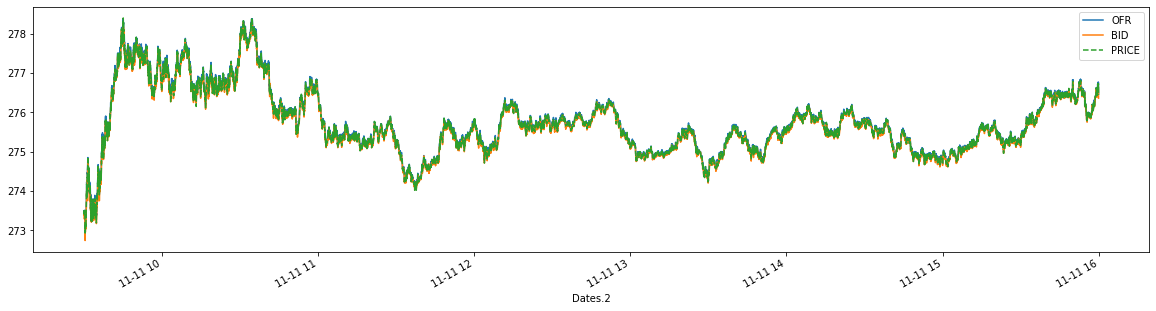

Reading file new_data/Facebook - FE570.xlsx...
BEST_BID    196882
Name: Type, dtype: int64
BEST_ASK    238290
Type             1
Name: Type.1, dtype: int64
TRADE    79670
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  196882.000000  196882.000000
mean      237.947687       1.867875
std         1.121717       3.505026
min       235.510000       1.000000
25%       237.120000       1.000000
50%       237.770000       1.000000
75%       238.920000       2.000000
max       240.820000     158.000000
>> ASK
             Price.1         Size.1
count  238290.000000  238290.000000
mean      237.881406       2.592131
std         1.077029      18.726817
min       235.540000       1.000000
25%       237.120000       1.000000
50%       237.750000       1.000000
75%       238.660000       2.000000
max       240.840000     779.000000
>> TRADE
            Price.2        Size.2
count  79670.000000  7.967000e+04
mean     238.157546  2.803956e+02
std        1.147054  1.552117e+04
min      235.550000  0.000000e+00
25%      237.290000  1.000000e+02
50%      237.960000  1.000000e+02
75%      239.150000  1.500000e+02
max      240

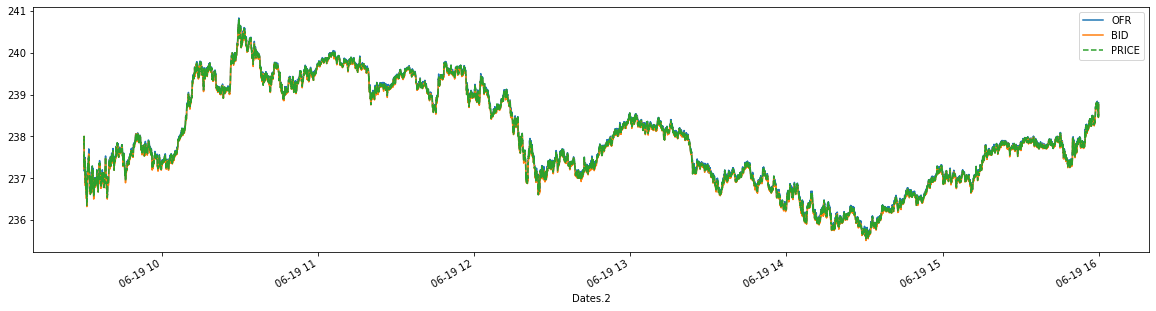

In [293]:
for i in [1,2]:
    q, t = process_tqdata('new_data/Facebook - FE570.xlsx', sheet_name=i)
    t.to_csv(f'new_data/processed/Facebook_{i+1}_t.csv', index=False)
    q.to_csv(f'new_data/processed/Facebook_{i+1}_q.csv', index=False)

# All other data

AAPL ------------------------------
Reading file new_data/AAPL - FE570.xlsx...
BEST_BID    922848
Type             4
Name: Type, dtype: int64
BEST_ASK    989519
Type             4
Name: Type.1, dtype: int64
TRADE    328877
Type          1
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  922848.000000  922848.000000
mean      110.511890       9.972646
std         0.512688      14.836727
min       108.720000       1.000000
25%       110.220000       4.000000
50%       110.640000       8.000000
75%       110.890000      13.000000
max       111.450000     621.000000
>> ASK
             Price.1         Size.1
count  989519.000000  989519.000000
mean      110.506245       9.817569
std         0.532446      17.318085
min       108.730000       1.000000
25%       110.230000       4.000000
50%       110.650000       8.000000
75%       110.890000      13.000000
max       111.470000    1050.000000
>> TRADE
             Price.2        Size.2
count  328877.000000  3.288770e+05
mean      110.472370  2.881892e+02
std         0.582095  9.719031e+03
min       108.730000  0.000000e+00
25%       110.200000  1.000000e+02
50%       110.630000  1.000000e+02
75%       110.900000  2.000000e+02
max 

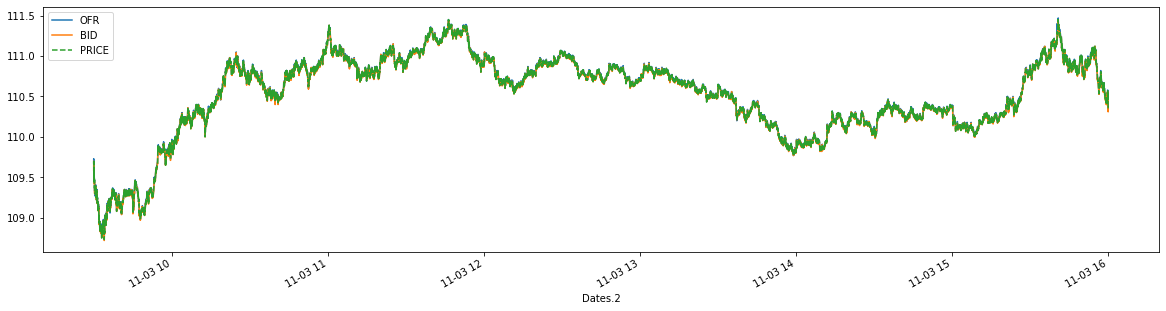

Reading file new_data/AAPL - FE570.xlsx...
BEST_BID    916586
Type             4
Name: Type, dtype: int64
BEST_ASK    990338
Type             4
Name: Type.1, dtype: int64
TRADE    327736
Type          1
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  916586.000000  916586.000000
mean      118.605024      10.100144
std         0.664027       9.412198
min       116.440000       1.000000
25%       118.050000       4.000000
50%       118.810000       8.000000
75%       119.200000      14.000000
max       119.710000     599.000000
>> ASK
             Price.1         Size.1
count  990338.000000  990338.000000
mean      118.621251      13.432991
std         0.662738      51.968116
min       116.450000       1.000000
25%       118.060000       4.000000
50%       118.860000       8.000000
75%       119.210000      14.000000
max       119.740000    1392.000000
>> TRADE
             Price.2        Size.2
count  327736.000000  3.277360e+05
mean      118.567794  2.696278e+02
std         0.712709  9.297456e+03
min       116.440000  0.000000e+00
25%       118.020000  1.000000e+02
50%       118.700000  1.000000e+02
75%       119.210000  2.000000e+02
max 

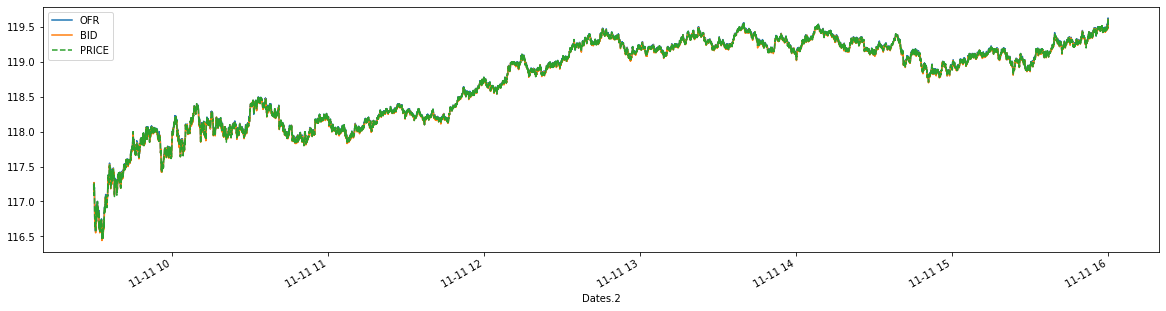

Reading file new_data/AAPL - FE570.xlsx...
BEST_BID    509298
Type             2
Name: Type, dtype: int64
BEST_ASK    546081
Type             2
Name: Type.1, dtype: int64
TRADE    192590
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  509298.000000  509298.000000
mean      350.132906       2.225805
std         3.083766       5.195198
min       345.140000       1.000000
25%       347.680000       1.000000
50%       349.290000       1.000000
75%       353.350000       2.000000
max       356.730000     201.000000
>> ASK
             Price.1         Size.1
count  546081.000000  546081.000000
mean      350.236197       2.190353
std         3.125458       4.919766
min       345.190000       1.000000
25%       347.710000       1.000000
50%       349.400000       1.000000
75%       353.460000       2.000000
max       356.960000     275.000000
>> TRADE
             Price.2        Size.2
count  192590.000000  1.925900e+05
mean      350.241043  2.677685e+02
std         3.030526  3.314287e+04
min       345.150000  0.000000e+00
25%       347.930000  1.000000e+02
50%       349.570000  1.000000e+02
75%       353.295000  1.500000e+02
max 

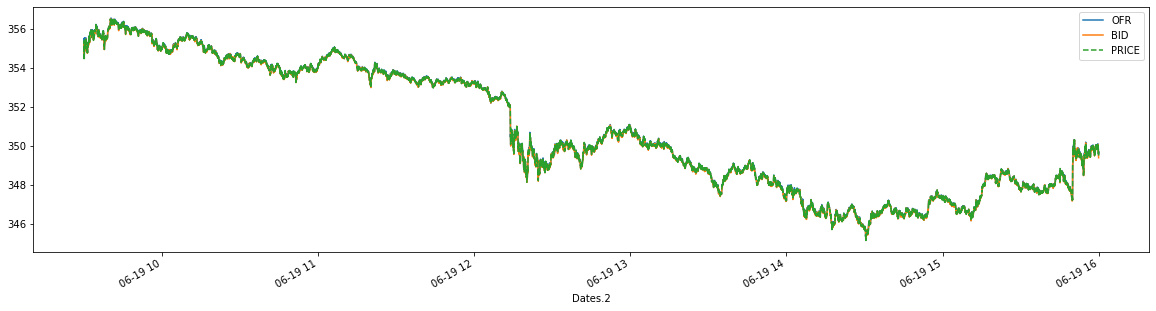

Amazon ------------------------------
Reading file new_data/Amazon - FE570.xlsx...
BEST_BID    70733
Name: Type, dtype: int64
BEST_ASK    67546
Name: Type.1, dtype: int64
TRADE    13165
Name: Type.2, dtype: int64
Fixing datetime...



Fix numeric values
Checking for outliers...
>> BID
              Price          Size
count  70733.000000  70733.000000
mean    3047.615598      1.241684
std       20.995887      1.363714
min     2980.520000      1.000000
25%     3044.420000      1.000000
50%     3054.280000      1.000000
75%     3060.360000      1.000000
max     3074.500000     38.000000
>> ASK
            Price.1        Size.1
count  67546.000000  67546.000000
mean    3049.311355      1.344447
std       20.685308      1.184198
min     2981.310000      1.000000
25%     3046.410000      1.000000
50%     3055.290000      1.000000
75%     3061.990000      1.000000
max     3075.000000     26.000000
>> TRADE
            Price.2         Size.2
count  13165.000000   13165.000000
mean    3046.244260     155.787239
std       22.275971    1313.088451
min     2980.980000       0.000000
25%     3041.320000     100.000000
50%     3053.380000     100.000000
75%     3060.670000     100.000000
max     3074.900000  143075.000000
Remov

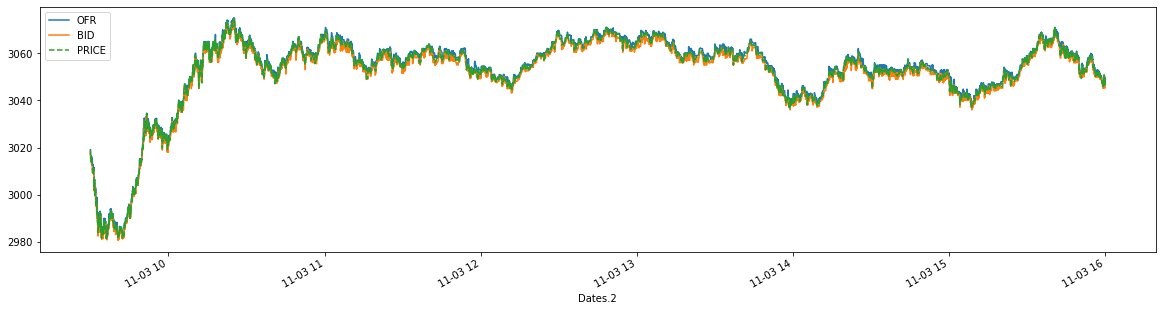

Reading file new_data/Amazon - FE570.xlsx...
BEST_BID    70939
Name: Type, dtype: int64
BEST_ASK    76875
Name: Type.1, dtype: int64
TRADE    10156
Name: Type.2, dtype: int64
Fixing datetime...



Fix numeric values
Checking for outliers...
>> BID
              Price          Size
count  70939.000000  70939.000000
mean    3115.566181      1.338009
std       15.241075      3.140482
min     3050.000000      1.000000
25%     3110.640000      1.000000
50%     3119.360000      1.000000
75%     3125.010000      1.000000
max     3143.000000     94.000000
>> ASK
            Price.1        Size.1
count  76875.000000  76875.000000
mean    3116.974462      1.290068
std       15.528219      1.159457
min     3050.810000      1.000000
25%     3112.080000      1.000000
50%     3120.990000      1.000000
75%     3126.670000      1.000000
max     3145.000000     30.000000
>> TRADE
            Price.2         Size.2
count  10156.000000   10156.000000
mean    3111.018363     167.429204
std       19.461234    2223.626147
min     3050.000000       0.000000
25%     3101.852500     100.000000
50%     3117.530000     100.000000
75%     3125.000000     100.000000
max     3139.150000  217700.000000
Remov

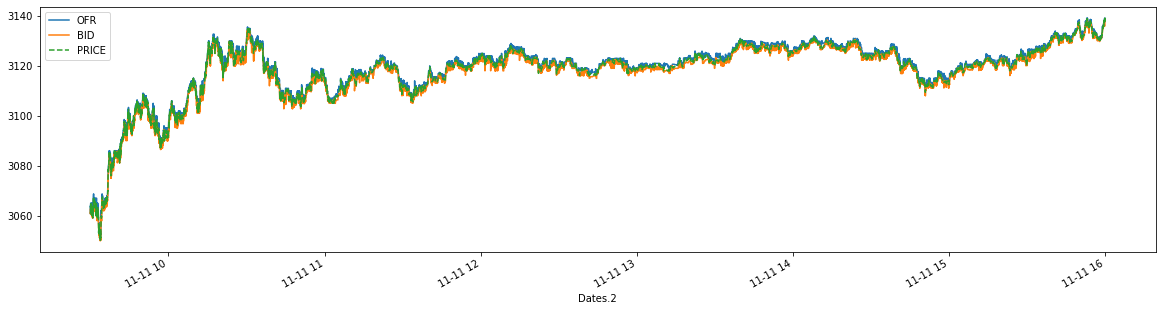

Reading file new_data/Amazon - FE570.xlsx...
BEST_BID    129850
Name: Type, dtype: int64
BEST_ASK    184026
Name: Type.1, dtype: int64
TRADE    14709
Name: Type.2, dtype: int64
Fixing datetime...



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  129850.000000  129850.000000
mean     2677.788343       1.290058
std         7.381774       0.958042
min      2659.000000       1.000000
25%      2672.060000       1.000000
50%      2678.220000       1.000000
75%      2682.580000       1.000000
max      2696.910000      27.000000
>> ASK
             Price.1         Size.1
count  184026.000000  184026.000000
mean     2679.074873       1.518851
std         7.512139       2.988105
min      2660.590000       1.000000
25%      2673.190000       1.000000
50%      2678.670000       1.000000
75%      2683.820000       1.000000
max      2697.770000     102.000000
>> TRADE
            Price.2        Size.2
count  14709.000000  1.470900e+04
mean    2679.330126  2.246729e+02
std        7.707835  8.831595e+03
min     2659.000000  0.000000e+00
25%     2673.660000  1.000000e+02
50%     2679.600000  1.000000e+02
75%     2684.170000  1.000000e+02
max     2697

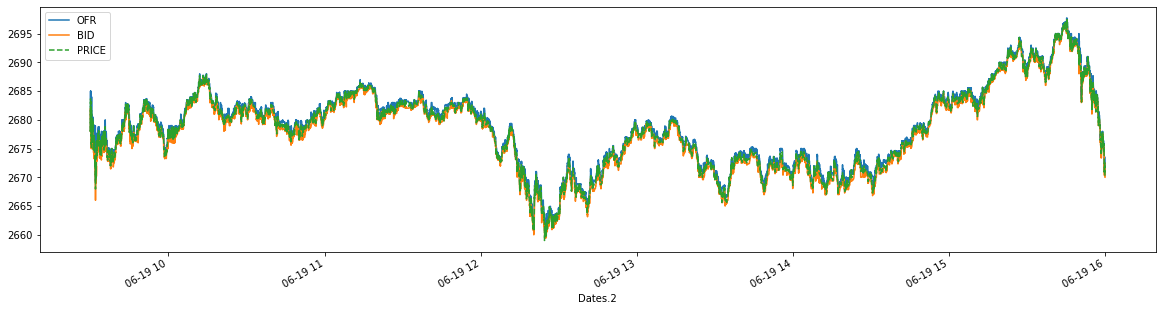

TSLA ------------------------------
Reading file new_data/TSLA - FE570.xlsx...
BEST_BID    351296
Type             1
Name: Type, dtype: int64
BEST_ASK    341263
Type             1
Name: Type.1, dtype: int64
TRADE    113902
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  351296.000000  351296.000000
mean      421.341691       1.796684
std         3.937946       3.862619
min       406.640000       1.000000
25%       421.120000       1.000000
50%       422.600000       1.000000
75%       423.560000       2.000000
max       427.650000     200.000000
>> ASK
             Price.1         Size.1
count  341263.000000  341263.000000
mean      421.649949       2.382063
std         3.732327      10.463997
min       406.750000       1.000000
25%       421.500000       1.000000
50%       422.730000       1.000000
75%       423.670000       2.000000
max       427.770000     372.000000
>> TRADE
             Price.2         Size.2
count  113902.000000  113902.000000
mean      420.966579     212.228495
std         4.379256    1447.194659
min       406.690000       0.000000
25%       420.308250     100.000000
50%       422.600000     100.000000
75%       423.730000     200.000

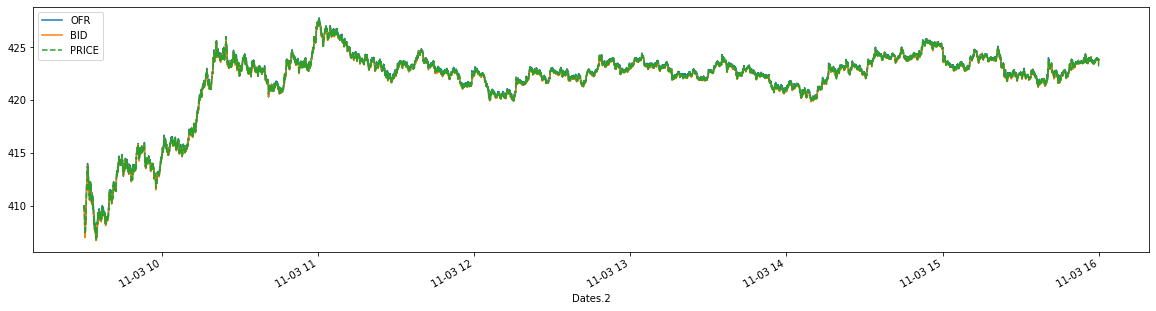

Reading file new_data/TSLA - FE570.xlsx...
BEST_BID    172007
Name: Type, dtype: int64
BEST_ASK    194119
Name: Type.1, dtype: int64
TRADE    56698
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  172007.000000  172007.000000
mean      415.412490       1.568669
std         1.181426       2.235271
min       410.530000       1.000000
25%       414.630000       1.000000
50%       415.530000       1.000000
75%       416.300000       2.000000
max       418.640000     100.000000
>> ASK
             Price.1         Size.1
count  194119.000000  194119.000000
mean      415.444135       1.736296
std         1.193709       3.251152
min       410.650000       1.000000
25%       414.700000       1.000000
50%       415.550000       1.000000
75%       416.320000       2.000000
max       418.700000      94.000000
>> TRADE
            Price.2         Size.2
count  56698.000000   56698.000000
mean     415.421377     207.937299
std        1.332168    1731.586330
min      410.580000       0.000000
25%      414.590000     100.000000
50%      415.550000     100.000000
75%      416.400000     190.000000
max 

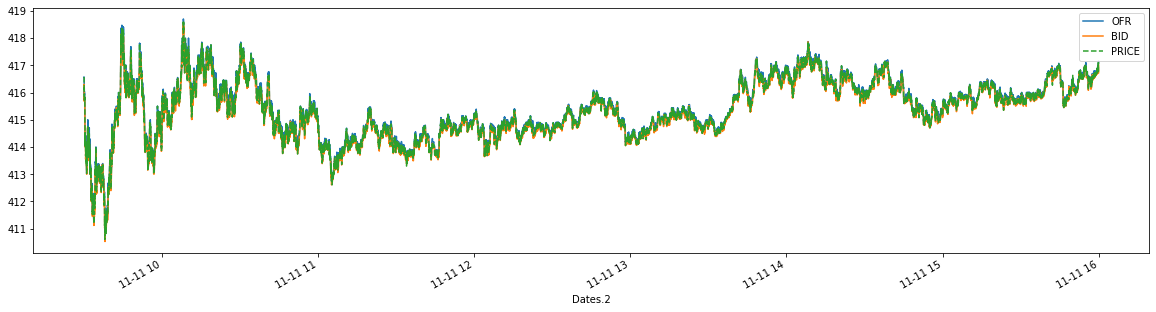

Reading file new_data/TSLA - FE570.xlsx...
BEST_BID    152494
Name: Type, dtype: int64
BEST_ASK    197191
Name: Type.1, dtype: int64
TRADE    28831
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  152494.000000  152494.000000
mean     1001.054298       1.491082
std         4.638697       2.043133
min       991.280000       1.000000
25%       997.850000       1.000000
50%      1000.060000       1.000000
75%      1005.210000       1.000000
max      1019.530000      90.000000
>> ASK
             Price.1         Size.1
count  197191.000000  197191.000000
mean     1000.663618       1.309664
std         4.505913       1.655484
min       991.870000       1.000000
25%       997.680000       1.000000
50%       999.680000       1.000000
75%      1003.120000       1.000000
max      1019.800000      85.000000
>> TRADE
            Price.2         Size.2
count  28831.000000   28831.000000
mean    1001.965166     186.338351
std        5.084956    1903.542595
min      991.340000       0.000000
25%      998.190000     100.000000
50%     1000.580000     100.000000
75%     1006.680000     150.000000
max 

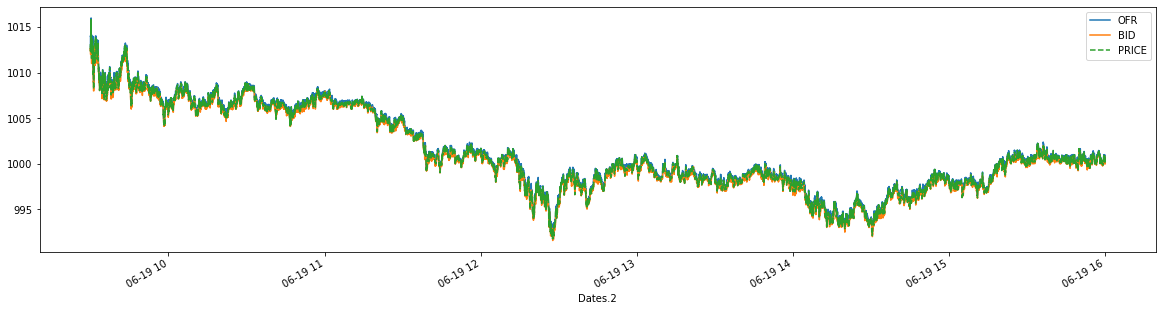

UAL ------------------------------
Reading file new_data/UAL - FE570.xlsx...
BEST_BID    180330
Name: Type, dtype: int64
BEST_ASK    215740
Type             1
Name: Type.1, dtype: int64
TRADE    57996
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  180330.000000  180330.000000
mean       34.113929       7.828104
std         0.199045       9.930013
min        33.790000       1.000000
25%        33.960000       3.000000
50%        34.050000       5.000000
75%        34.210000      10.000000
max        34.670000     230.000000
>> ASK
             Price.1         Size.1
count  215740.000000  215740.000000
mean       34.115931       9.596032
std         0.196444      10.384251
min        33.800000       1.000000
25%        33.970000       4.000000
50%        34.050000       7.000000
75%        34.210000      12.000000
max        34.690000     258.000000
>> TRADE
            Price.2         Size.2
count  57996.000000   57996.000000
mean      34.116192     245.778209
std        0.204530     977.530862
min       33.760000       0.000000
25%       33.960000     100.000000
50%       34.050100     100.000000
75%       34.210000     114.000000
max 

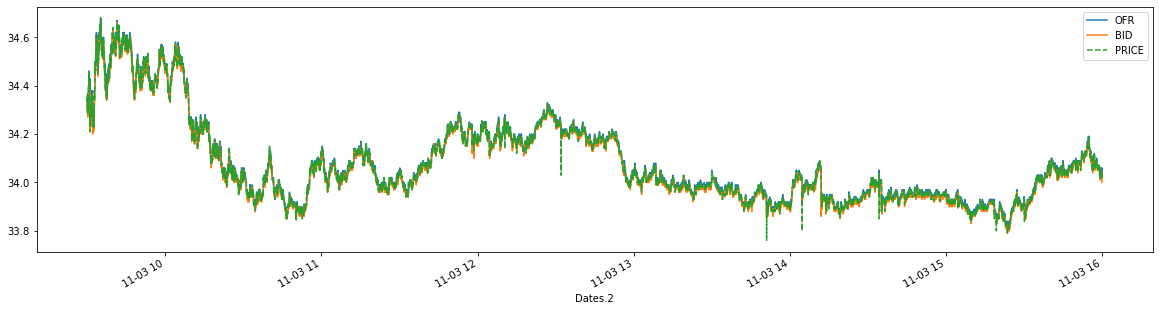

Reading file new_data/UAL - FE570.xlsx...
BEST_BID    312904
Type             1
Name: Type, dtype: int64
BEST_ASK    324421
Type             1
Name: Type.1, dtype: int64
TRADE    63178
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  312904.000000  312904.000000
mean       38.873645      13.050463
std         0.350805      15.253333
min        38.190000       1.000000
25%        38.510000       4.000000
50%        38.970000       8.000000
75%        39.130000      17.000000
max        40.220000     388.000000
>> ASK
             Price.1         Size.1
count  324421.000000  324421.000000
mean       38.892824      13.300489
std         0.339339      24.210814
min        38.200000       1.000000
25%        38.570000       4.000000
50%        38.980000       9.000000
75%        39.130000      17.000000
max        40.250000    1007.000000
>> TRADE
            Price.2         Size.2
count  63178.000000   63178.000000
mean      38.882306     284.415176
std        0.358451    1882.950327
min       38.190100       0.000000
25%       38.530000     100.000000
50%       38.967300     100.000000
75%       39.130000     200.000000
max 

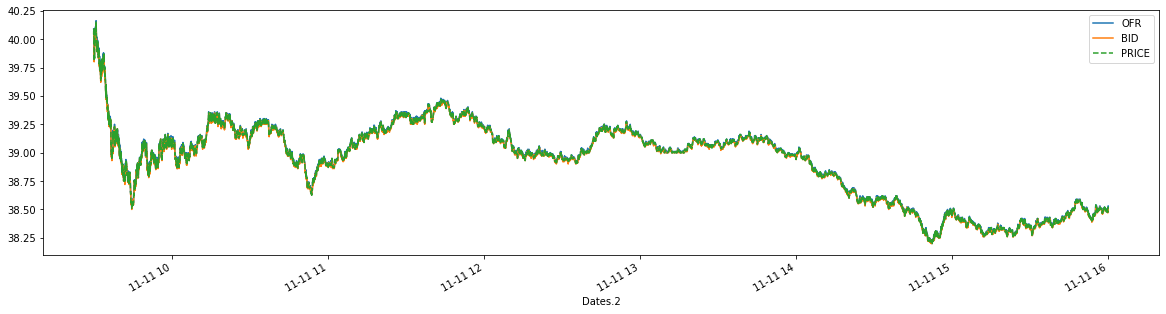

Reading file new_data/UAL - FE570.xlsx...
BEST_BID    590453
Type             2
Name: Type, dtype: int64
BEST_ASK    596656
Type             2
Name: Type.1, dtype: int64
TRADE    221349
Type          1
Name: Type.2, dtype: int64
Fixing datetime...


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:792: UserWarning: Discarding nonzero nanoseconds in conversion
  return func(*args, **kwargs)



Fix numeric values
Checking for outliers...
>> BID
               Price           Size
count  590453.000000  590453.000000
mean       37.742325      13.025406
std         1.100545      19.609469
min        35.760000       1.000000
25%        36.850000       4.000000
50%        37.460000       8.000000
75%        38.850000      17.000000
max        40.450000     781.000000
>> ASK
             Price.1         Size.1
count  596656.000000  596656.000000
mean       37.766912      13.381927
std         1.095168      28.372898
min        35.780000       1.000000
25%        36.880000       4.000000
50%        37.530000       8.000000
75%        38.860000      17.000000
max        40.500000    1375.000000
>> TRADE
             Price.2        Size.2
count  221349.000000  2.213490e+05
mean       37.731375  4.092524e+02
std         1.105718  1.293072e+04
min        35.762600  0.000000e+00
25%        36.860000  1.000000e+02
50%        37.310000  1.000000e+02
75%        38.860000  3.000000e+02
max 

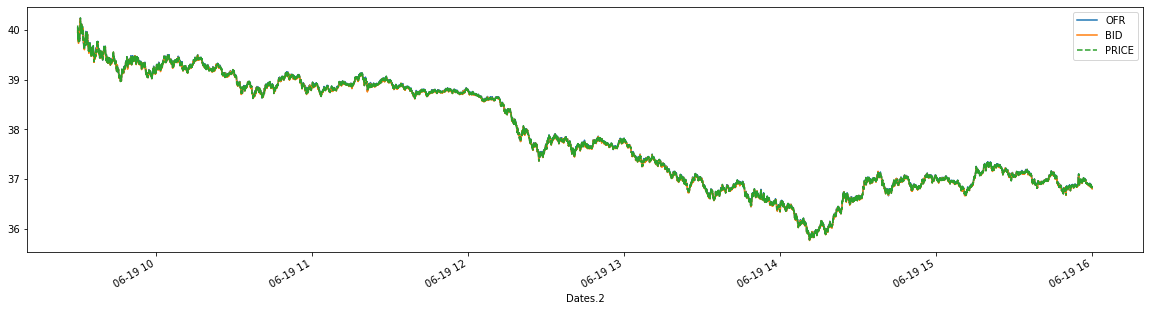

In [294]:
for company in ['AAPL', 'Amazon', 'TSLA', 'UAL']:
    print(company, "-"*30)
    for i in [0,1,2]:
        try:
            q, t = process_tqdata(f'new_data/{company} - FE570.xlsx', sheet_name=i)
            t.to_csv(f'new_data/processed/{company}_{i+1}_t.csv')
            q.to_csv(f'new_data/processed/{company}_{i+1}_q.csv')
        except:
            print(f"ERROR: could not run {company} for sheet {i}")